# Lab 3 Solutions

In this lab, we'll be using classes and functions to build a pipeline which will automatically extract the fluxes of stars in an image. We're all familiar with aperture photometry, but in this case, we're going to take the additional step of convolving our image with a PSF. 

Our pipeline will be split into several steps. 

1. Reading in an image 
2. Finding the local peaks in the image (the stars)
3. Calculating the centroid of each peak region 
4. Convolving with the PSF and extracting flux. 



## Problem 1
In this problem, we'll load in the image(s) for use and begin constructing our `PSFPhot` class. 

### Problem 1.1
Create a script (`.py` file) in this directory and copy into it your `load_fits()` and final `implot()` functions from last lab. Then import them here. 

Use your `load_fits()` to read in in the image `2020-04-15-0001.fits` and plot it with `implot()`. 

This image was taken of the M81/M82 field using the Dragonfly Telephoto Array (in a narrowband configuration). 

In [519]:
def load_fits(fpath,extension=0):
    '''
    Function to load a FITS file into python
    
    Parameters
    ----------
    fpath: str
        path to the FITS file to load. must end in .fit/.fits/.FIT/.FITS
    extension: int (optional)
        extension of the FITS file to load. (default 0)
        
    Returns
    -------
    header: dict_like
        the read in header of the chosen extension, as a python dictionary
    data: array_like
        the data contained in the extension, whether an image or table.
    '''
    with fits.open(fpath) as hdu:
        header = hdu[extension].header
        data = hdu[extension].data
    return header, np.array(data,dtype=float)
def implot(image,figsize=(15,13),cmap='gray_r',scale=0.5,colorbar=False,header=None,wcs=None,**kwargs):
    '''
    Plot an astronomical image, setting default options and easy tweaking of parameters
    
    Parameters
    ----------
    image: array_like
        2D array containing an astronomical image to be plotted. Cutouts should be input as cutout.data.
    figsize: tuple, optional
        figure size to use. Default: (15,13)
    cmap: str, optional
        Colormap to use for the image. Default: 'gray_r'
    scale: float, optional
        By default, function will scale image to some number of standard deviations about the mean pixel value. Scale sets this number (or fraction). Default: 0.5.
    colorbar: bool, optional
        Whether to add a colorbar or not. Default: False
    header: dict, optional
        If input, function will attempt to create a WCS object from header and plot in celestial coordinates. Default: None
    wcs: WCS object
        If input, the function will plot using a projection set by the WCS. Default: None
    **kwargs
        Additional arguments are passed to matplotlib plotting commands. Currently supported: vmin, vmax.
        
    Returns
    -------
    fig, ax
        figure and axes objects containing currently plotted data.
    '''
    if (header==None) and (wcs==None):
        fig, ax = plt.subplots(figsize=figsize)
    elif wcs is not None:
        fig, ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
        ax.set_xlabel('Right Ascension [hms]',fontsize=15)
        ax.set_ylabel('Declination [degrees]',fontsize=15)
        ax.coords.grid(color='gray', alpha=0.5, linestyle='solid')
    elif header is not None:
        wcs = WCS(header)
        fig, ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
        ax.set_xlabel('Right Ascension [hms]',fontsize=15)
        ax.set_ylabel('Declination [degrees]',fontsize=15)
        ax.coords.grid(color='gray', alpha=0.5, linestyle='solid')
    mu = np.mean(image)
    s = np.std(image)
    dvmin = mu - scale*s
    dvmax = mu + scale*s
    if all(['vmin','vmax']) in kwargs.keys():
        im = ax.imshow(image,origin='lower',cmap=cmap,vmin=kwargs['vmin'],vmax=kwargs['vmax'])
    elif 'vmin' in kwargs.keys():
        im = ax.imshow(image,origin='lower',cmap=cmap,vmin=kwargs['vmin'],vmax=dvmax)
    elif 'vmax' in kwargs.keys():
        im = ax.imshow(image,origin='lower',cmap=cmap,vmin=dvmin,vmax=kwargs['vmax'])
    else:
        im = ax.imshow(image,origin='lower',cmap=cmap,vmin=dvmin,vmax=dvmax)
    if colorbar:
        cbar = plt.colorbar(im,ax=ax)
    ax.tick_params(direction='in',length=9,width=1.5,labelsize=15)
    
    return fig, ax

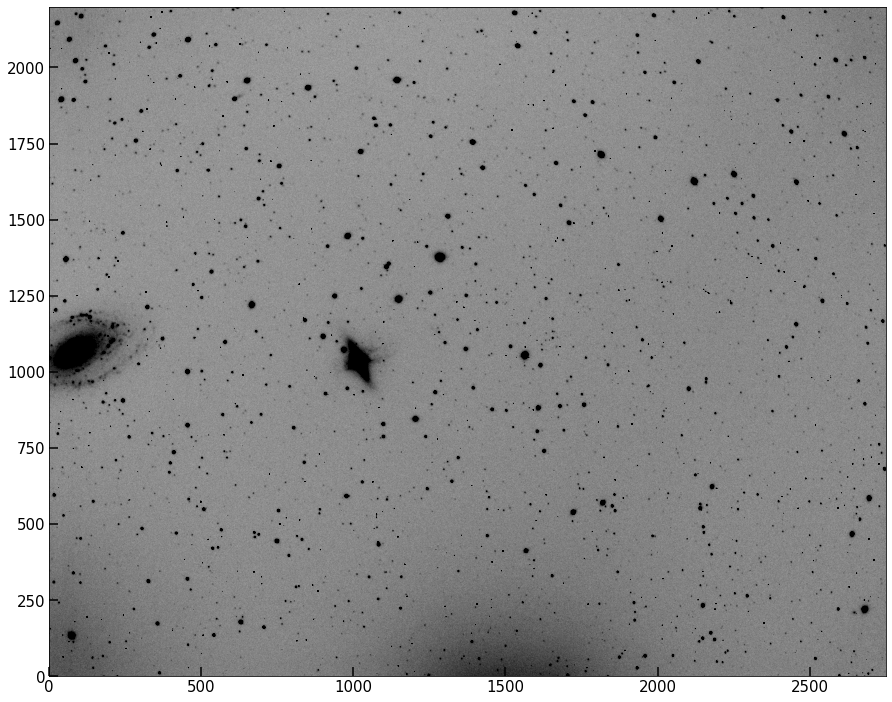

In [52]:
header, image= load_fits('2020-04-15-0001.fits')
implot(image);

M82 should be visible left of center, M81 on the left hand edge. Two features caused by detector amp glow are also visible at the bottom of the image. 

### Problem 1.2 

Finish the syntax for creating the `PSFPhot` class below. The init for the class should ask for three string paths: one to an image, one to a dark file, and one to a flat file. Within `__init__()`, use your `load_fits()` function to get the just the data image and header into the class. Store them as class attributes `self.data_init` and `self.data_header`.

Don't forget to add a docstring to your init! It doesn't return anything, but sets the initial attributes.

In [ ]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)

### Problem 1.3 

Add a method to your class called `dark_subtract()` which takes an image and a string-path to a dark file. Use `load_fits()` to read it in the dark, and subtract it from the image, and return the output. 

Add another method called `flat_field()` which takes in an image and a string-path to a flatfield file. Use `load_fits()` to read it in, normalize it to its maximum value, and divide the input image by it. 

Finally, within your init function, set a new class attribute called `self.data_calibrated = flat_field(dark_subtract(self.data_init,dark_path),flat_path)`. (That is, run your calibrators. You need not nest the function, but these are simple enough to do so). 

Use `implot()` to plot both the `data_init` and `data_calibrated` and show that your calibrations worked. 

In [527]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        dark_im, = load_fits(dark_path)
        return image - dark_im
    
    def flat_field(self,image,flat_path):
        flat_im, = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im
    

### Problem 1.4 

The final step in setting up our image for proper analysis is the subtraction of the globally varying sky background. Performing that fit (generally a low order 2D polynomial of some kind) is beyond the scope of this lab, but we encourage you to look into this step more if you are interested. 

Instead, we're going to return to the `sep` package and take advantage of its background estimation feature. Recall it reads in the base image array and a separate mask. We want the user of this class to be able to supply a mask, so we won't run this step automatically in `__init__()`.

Using the same stucture as in Lab 2, we'll calculate the background using `sep`. This time though, add a method to your class that called `subtract_background(self,mask=None)`. Inside, use sep to again find, e.g., `bkg.back()`, and subtract it from `self.data_calibrated`. You should set `mask=mask` in the sep call. For convenient access, store the output of `bkg.back()` in a class attribute called `self.background`, and then set `self.image` equal to the background subtracted image. This method is known as a *setter*, because we're setting a class attribute but not returning anything. 

It can be handy here to add a print statement at the end of the method saying something like `"Background estimated; output saved to attribute 'image' "`. Since this is the main image we'll be using from now on, I've elected to give it the short name `image`. You may rather use something like `data_bg_sub`, for example

```{warning}
Don't forget about the C order switch. 
```

In [528]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        dark_im, = load_fits(dark_path)
        return image - dark_im
    
    def flat_field(self,image,flat_path):
        flat_im, = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im
    
    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute data_bg_sub')
    

Now, when the class gets instantiated, users will run the subtract background method, but will have the option of supplying a manual mask if they choose. 

## Problem 2

Our goal is to estimate the PSF of the above image, then measure fluxes of the stars and galaxies here accounting for the PSF. 

To start this process, we need to locate the stars in this image. We saw how to segment an image using `sep` last time, but in this lab we are going to carry out this step ourselves, using two methods. 

### Problem 2.1

Before we do this, we want to take the step of masking out several regions of the image which may register as peaks but which are not nicely isolated stars. In particular, the two galaxies need to be masked out when both estimating the background and when looking for point sources.


Create a mask of the dimensions of the image data, containing `False` everywhere except where we want to mask out the galaxies (rough rectangular regions are fine for this masking). It's easiest to make the full array `False` first, then set the regions we want to mask to `True` via image indexing. 

Add a method to your class called `set_image_mask(self,mask)` which overwrites `self.data` with a numpy masked array containing what used to be `self.image` as the data, with a mask that the user inputs. Test that this has worked; you should get an image like the one below.

```{warning}
If we have the memory to, it's often worth avoiding overwriting class attributes. Here, we could set the masked image as `self.image_masked`, for example. I've elected not to here for two reasons. One: simplicity. Two: the unmasked version of the image is easily accessible still via `self.image.data`, the data attribute of numpy masked arrays.
```

In [535]:
# Solution
mask = np.zeros(image.shape,dtype=bool)
mask[900:1250,0:300] = True
mask[850:1200,900:1100] = True

class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        h,dark_im = load_fits(dark_path)

        return np.subtract(image,dark_im)
    
    def flat_field(self,image,flat_path):
        h,flat_im = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im

    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute image')
    
    def set_image_mask(self,mask):
        if hasattr(self,'image'):
            self.image = np.ma.masked_array(self.image,mask=mask)
        else:
            self.image = np.ma.masked_array(self.data_calibrated,mask=mask)

Background estimated; output saved to attribute image


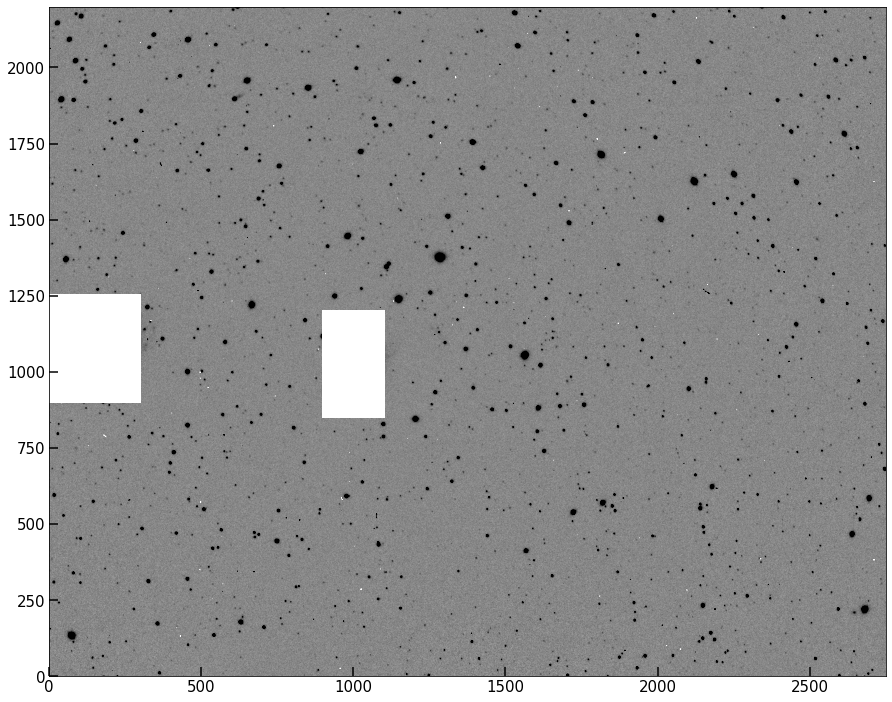

In [536]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask=mask)
pipe.set_image_mask(mask)
implot(pipe.image);


```{note}
In our instance here, the mask we will use when background subtracting is the same as the one we'll use for blocking out regions from being included in peak finding and such. But our code is flexible enough to, e.g., mask when background-subtracting but not when peak finding, or vice versa. Our mask setter only affects the image data, and the mask argument in the subtract background method only affects background subtraction.
```

```{tip}
As it stands, `set_image_mask()` can only be run *after* `subtract_background()`, because that method sets `self.image` for the first time. We can use the `hasattr(self,'image')` check to see, when `set_image_mask()` is run, if that previous method was already run. For now, it's ok to assume the user will use the class in order, but it can be helpful to either raise an exception or apply the mask to `data_calibrated` if the other method hasn't been run.
```

Plot the `.background` attribute. It seems our image has a spatially varying background that includes a gradient across the image.

(<Figure size 1080x936 with 2 Axes>, <AxesSubplot:>)

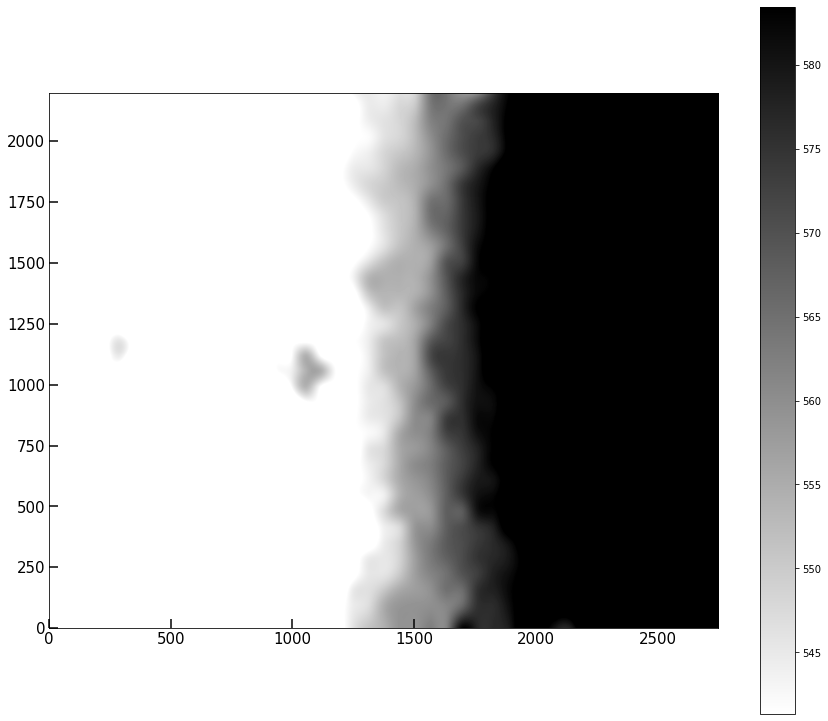

In [538]:
implot(pipe.background,colorbar=True)

### Problem 2.2 

Using what we have so far, 

- instantiate an object using your class, which should handle the initial calibrations as well
- run its `subtract_background()` method using the manual mask you created above
- also run its `set_image_mask()` method using the same mask. 

We now, finally, are ready to begin using this masked, background subtracted, dark subtracted, flat fielded image to search for stars and do photometry.

Background estimated; output saved to attribute image


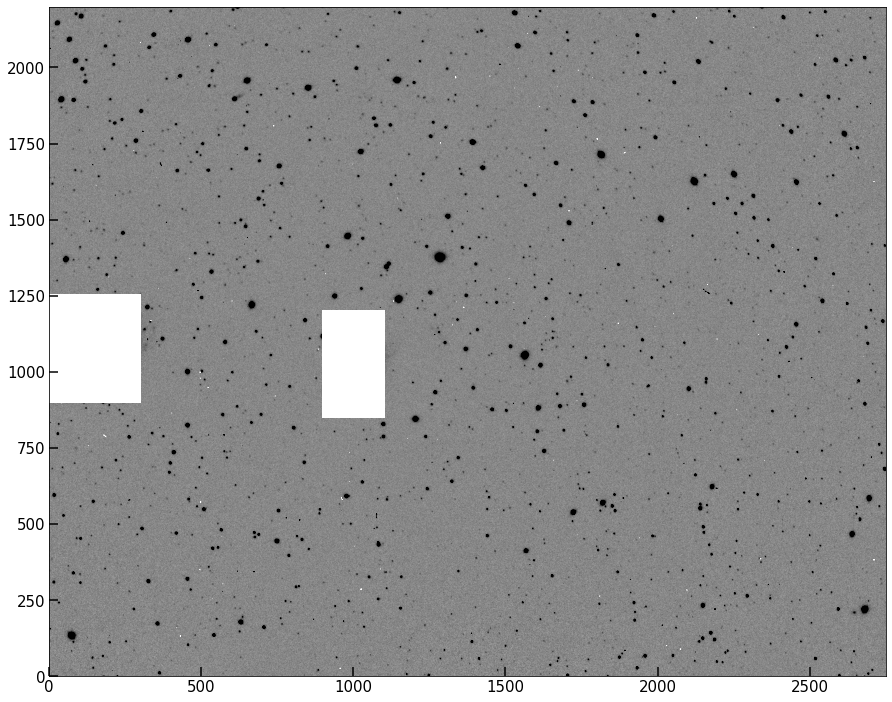

In [539]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask)
pipe.set_image_mask(mask)
implot(pipe.image);

### Problem 2.2

Now that we have the appropriate image regions masked, we can move on to the peak finder. 

The "fast" or "efficient" method of doing this involves some scipy filtering operations. But for our purposes, the "slow way" (iterating over the image pixels) takes ~few seconds to run, and is worth doing to build intuition. 

Add a method to your class to find peaks in an image by looping over each pixel and checking its neighbors, with a "peak" being defined as a region of higher flux than all adjacent pixels (i.e., the 8 surrounding pixels). In order to not pick up random noise pixels, also take an input called `threshold`. Within your algorithm, don't return any pixels which are "peaks" but for which the pixel value is below this threshold. 

```{hint}
:dropdown: 
This algorithm needs to avoid the edges of the image (since indexing "i+1" won't work there). Creating a 1 pixel "buffer" in your looping will prevent this. 
```

In [70]:
# Solution
def find_peaks(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    
    Parameters
    ----------
    image: array_like
        2D array containing the image of interest.
    threshold: float
        minimum pixel value for inclusion in search
    
    Returns
    -------
    peak_x_values, peak_y_values: array_like, array_like
        arrays containing the x and y coordinates of peak regions.
    '''
    peak_x_values = [] 
    peak_y_values = []
    edgewidth = 1
    for i in range(edgewidth, image.shape[0] - edgewidth):
        for j in range(edgewidth, image.shape[1] - edgewidth):
            pixel = image[i,j]
            if(pixel < threshold):
                continue
            if(pixel > image[i+1, j] and
               pixel > image[i-1, j] and
               pixel > image[i, j+1] and
               pixel > image[i, j-1] and
               pixel > image[i-1, j-1] and
               pixel > image[i+1, j-1] and
               pixel > image[i-1, j+1] and
               pixel > image[i+1, j+1]):
                peak_x_values.append(i)
                peak_y_values.append(j)
    return np.array(peak_x_values), np.array(peak_y_values)

The looping solution is slow, and will not scale well if we have to run on many images, but for one image is okay. 

There are several solutions which generally involve either **filtering** the image or **cross correlating** the image with a template. Here's one such solution.

In [399]:
from scipy.ndimage import maximum_filter

def findpeaks_maxfilter(image, threshold):
    '''
    Algorithm for finding peaks (above a threshold) in an image
    
    Parameters
    ----------
    image: array_like
        2D array containing the image of interest.
    threshold: float
        minimum pixel value for inclusion in search
    
    Returns
    -------
    peaks: array_like
        array containing the x and y coordinates of peak regions.
    '''
    neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
    # find local maximum for each pixel
    amax = maximum_filter(image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.
    
    peaks = np.where((image == amax) & (image >= threshold)) #find the pixels unaffected by the max filter.
    peaks = np.array([peaks[0],peaks[1]]).T
    return peaks

Let's take a moment to understand how this algorithm works. The key is in the `maximum_filter()` step. Filtering a 2D image is a process carried out in fourier space, which is what allows scipy to carry it out quickly. But what is maximum filtering?

```{admonition}Definition
Maximum Filtering is the process by which all pixels in local neighborhoods within an array are raised to the maximum value of any pixel in that neighborhood
```

Let's look at a 1D case. Below, I define a 1D array that has some peaks in it. 

In [110]:
array_1dpeaks = np.array([1,1,2,1,2,1,2,1,2,3,4,3,2,1,2,4,5,6,8,6,5,4,3,2,4,3,4,2,1,0.5,1,2,1,2,3,2])

Our data looks like this:

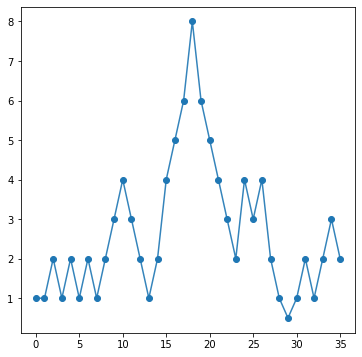

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9)
ax.plot(array_1dpeaks,'o',color='C0')

Let's now run the maximum filter on this data and plot it's output. I'm going to pick a neighborhood of 3, which means +/- 1 pixel around each location.

In [112]:
mf = maximum_filter(array_1dpeaks, footprint=np.ones(3,dtype=bool)) 

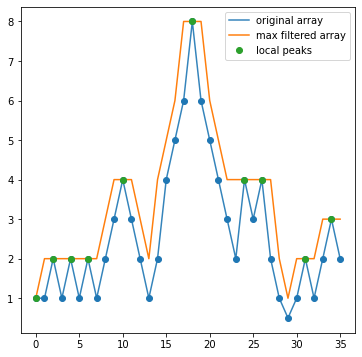

In [120]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(array_1dpeaks,lw=1.5,alpha=0.9,label='original array')
ax.plot(array_1dpeaks,'o',color='C0')
ax.plot(mf,label='max filtered array')
eq, = np.where(array_1dpeaks==mf)
ax.plot(np.arange(len(mf))[eq],mf[eq],'o',label='local peaks')
ax.legend();

What the filtering has done is for every 3 pixel neighborhood across this array, it's raised the value of all three pixels to the maximum value across the three. So we see that anywhere the three pixels were, e.g., (1,2,1), they are all now 2. What you should notice looking at this plot is that the max filtering has also identified true peaks in our data! Notice that the only spots where the orange curve (the max filtered version of the data) is equal to the original array is exactly at locations that are local maxima. This is because when applying max filtering to an array, the only values *unchanged* by the filtering are those that *are* local maxima (in the neighborhood defined). 

And thus, we have our peaks! All we need to do is find out `where()` the max filtered array equals the original array. Of course, we can also put in a threshold (in this example, maybe 2.5) to ensure low level noise doesn't enter in. This is why the `findpeaks_maxfilter()` function has a threshold option as well.

```{note}
You may notice that the first index in the array is marked as a peak, despite not being one. Edges are always troublesome with these algorithms, and they normally have multiple options for how edges are handled, e.g, interpolating a constant value, reflecting over the edge, etc. For our lab, we're not going to worry about this.
```


## Problem 2.3 

For the rest of the lab, you can either leave in your peak finder, or replace it with the max-filtering version (turning the function above into a method). Either way, your method should be runnable with no inputs, with an optional threshold argument to set a minimum flux value for inclusion.

Before you decide, explicitly find out how slow the loop is compared to the max filtering. 

Use the `%%timeit` magic command in your notebook to test how fast the two algorithms are respectively. If you were working with a sample of 1000 images, how long would the looping algorithm take compared to the max-filtering case?

```{hint}
Check out the "Timing Code" page in the "Quick Tips" sidebar tab of our website to see examples of using the `timeit` module.
```

In [123]:
%%timeit
yp,xp = find_peaks(image,threshold=m+3*s)

8.01 s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
%%timeit
pks = findpeaks_maxfilter(image,threshold=m+3*s)

142 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
8.01 / (142*0.001)

56.408450704225345

The max-filtering method is a factor of 56 faster than the loop! For 1000 images, it would take

In [134]:
(1000*8.06*u.s).to(u.hr)

<Quantity 2.23888889 h>

2.23 hours to run just the peak-finding part of the algorithm, compared to

In [136]:
(1000*(142*0.001)*u.s).to(u.min)

<Quantity 2.36666667 min>

2.3 minutes to run it using max filtering. Speed matters!

In [544]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        h,dark_im = load_fits(dark_path)

        return np.subtract(image,dark_im)
    
    def flat_field(self,image,flat_path):
        h,flat_im = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im

    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute image')
    
    def set_image_mask(self,mask):
        if hasattr(self,'image'):
            self.image = np.ma.masked_array(self.image,mask=mask)
        else:
            self.image = np.ma.masked_array(self.data_calibrated,mask=mask)
   
    def findpeaks_maxfilter(self,threshold=0):
            '''
            Algorithm for finding peaks (above a threshold) in an image

            Parameters
            ----------
            image: array_like
                2D array containing the image of interest.
            threshold: float
                minimum pixel value for inclusion in search

            Returns
            -------
            peaks: array_like
                array containing the x and y coordinates of peak regions.
            '''
            neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
            # find local maximum for each pixel
            amax = maximum_filter(self.image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.

            peaks = np.where((self.image == amax) & (self.image >= threshold)) #find the pixels unaffected by the max filter.
            peaks = np.array([peaks[0],peaks[1]]).T
            return peaks

### Problem 2.4 

Run your peakfinder on your masked image, and assemble the list of peaks you'll use moving forward. Your peakfinder method should save a class attribute `self.peak_locations` which contains the ($x,y$) pairs of points associated with your peaks. 


Plot up the original image, but use our "source circling" technique from last lab to circle all the peaks found in the masked image. I show mine below. 

```{hint}
Recall that `implot()` returns a set of `fig, ax`, so you can then plot the circles onto the same axis as the image.
```

Background estimated; output saved to attribute image


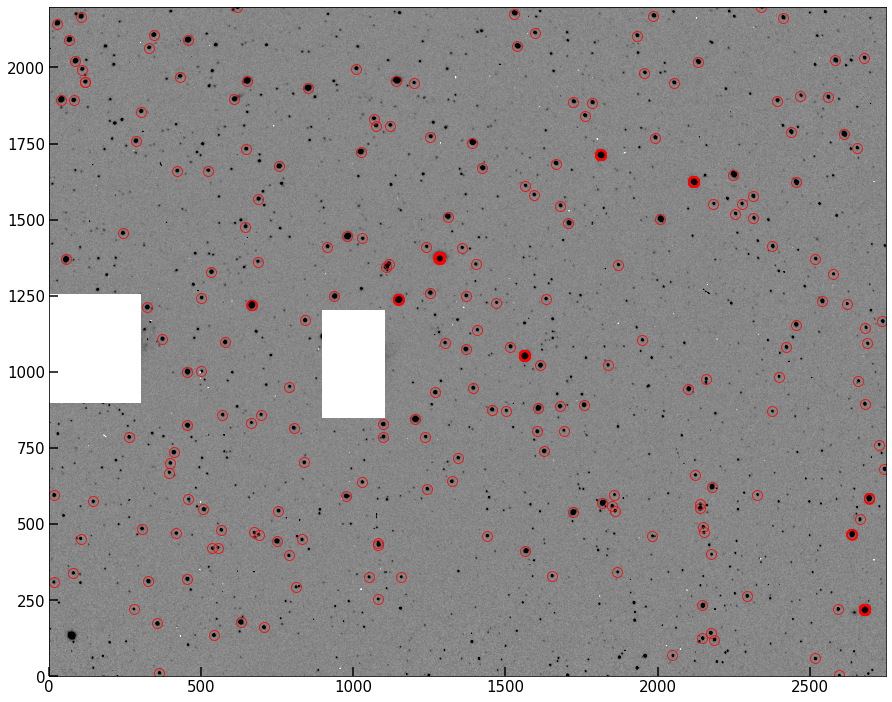

In [549]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask)
pipe.set_image_mask(mask)
peaks = pipe.findpeaks_maxfilter(threshold=np.mean(pipe.image)+2*np.std(pipe.image))
# Note that this is returned in row, column form (so y,x).
fig, ax = implot(pipe.image,scale=0.5)
ax.plot(pks[:,1],pks[:,0],'o',color='None',mec='r',ms=10,alpha=0.8);

### Problem 2.5 

This should look pretty good -- most of what's circled above is clearly a star/point source in the image. However, one problem with this method is that single hot pixels are going to be registered as peaks, even via the clever algorithm. We need a way to eliminate these from our sample before moving on. 

Adjust your peak-finder method to add in something that checks that not only is there a true peak, but that at least 4 of the pixels around the peak are also elevated in flux (I used 0.5 times the peak flux). The easiest way is to loop over the peaks after they're found and institute the check --- there are far fewer peaks than pixels, so this doesn't significantly affect the runtime. But feel free to find a cleverer solution!

```{warning}
Be careful with transpositions in this problem. when you plot coordinates, you plot(x,y), but when you index the image, you index image[y,x]. Always be tracking which is which! 
```

In [619]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        h,dark_im = load_fits(dark_path)

        return np.subtract(image,dark_im)
    
    def flat_field(self,image,flat_path):
        h,flat_im = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im

    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute image')
    
    def set_image_mask(self,mask):
        if hasattr(self,'image'):
            self.image = np.ma.masked_array(self.image,mask=mask)
        else:
            self.image = np.ma.masked_array(self.data_calibrated,mask=mask)
   
    def findpeaks_maxfilter(self,threshold=0):
            '''
            Algorithm for finding peaks (above a threshold) in an image

            Parameters
            ----------
            image: array_like
                2D array containing the image of interest.
            threshold: float
                minimum pixel value for inclusion in search

            Returns
            -------
            peaks: array_like
                array containing the x and y coordinates of peak regions.
            '''
            neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
            # find local maximum for each pixel
            amax = maximum_filter(self.image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.

            peaks = np.where((self.image == amax) & (self.image >= threshold)) #find the pixels unaffected by the max filter.
            peaks = np.array([peaks[0],peaks[1]]).T
            out_peaks = []
            for i in peaks:
                peak_flux = image[i[0],i[1]]
                mini_cutout = image[i[0]-1:i[0]+2,i[1]-1:i[1]+2]
                accept = np.where(mini_cutout>0.5*peak_flux)
                if len(accept[0]) > 7:
                    out_peaks.append(i)
            return np.array(out_peaks)

Re-find your peaks using your newer, better algorithm, and plot them below as before.

Background estimated; output saved to attribute image


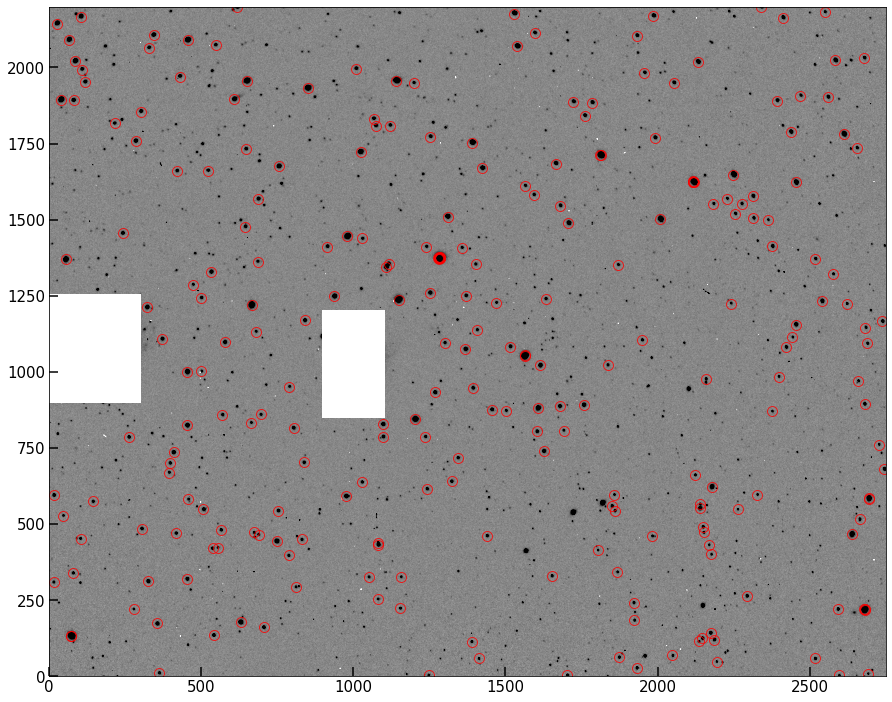

In [620]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask)
pipe.set_image_mask(mask)
peaks = pipe.findpeaks_maxfilter(threshold=np.mean(pipe.image)+3*np.std(pipe.image))
# Note that this is returned in row, column form (so y,x).
fig, ax = implot(pipe.image,scale=0.5)
ax.plot(peaks[:,1],peaks[:,0],'o',color='None',mec='r',ms=10,alpha=0.8);

Notice that we've decreased our total number of peaks. But you should find that now, everything currently circled looks like a bright, "resolved" star. (resolved insofar as the PSF is spreading the light of the star over multiple pixels). 

### Problem 2.6 

In your the image above, you should see that ~8-10 stars look like they are circled by several very closely overlapping circles all targeting the same star. Infer (or investigate and determine) why this has happened, and write your answer below. 




There are saturated stars in the image. When stars are saturated (at the peak value registered by the detector), they also don't have true peaks -- all values across the top of the star are the same max value (like a flat-top mesa). Our algorithm with max filtering thus registers all those pixels as peaks. 

## Problem 3 

We now have a function that can return the peaks in a given image. Our next step is going to be to estimate the exact center of those peaks (stars) using their **centroid**.

```{admonition}Definition
The centroid is the light-weighted-mean of a set of pixels. It is not always the maximum-valued pixel, and is determined to sub-pixel accuracy.
```

Many of you have seen the centroid formula, but as a reminder, it looks like this (in 1D):


$$
x_{\rm com} = \frac{\sum{x_i \hat{f}_i}}{\sum \hat{f}_i},
$$

where $x_i$ are the positions and $\hat{f}_i$ are the fluxes at those positions. 

In 2D, when working with images, the $x$ and $y$ centers of mass are independent, and the 2D centroid is just the location ($x_{\rm com}$, $y_{\rm com}$). 

### Problem 3.1 

Add a method to your class called `centroid_cutout()` which should read in an image (which will be a cutout around each star) and the $x$ and $y$ peak location returned by your peak finder, then create a window of NxN pixels around it (user-settable), and determine the centroid of this window. The $x,y$ location of this centroid should be returned.

One subtlety --- We want to use a window size greater than 1 pixel on either side of each peak. But because our peak finder is likely to have found peaks near the edge of the detector (both because it needs only 1 pixel-thick borders and because it handles edges), if we write a centroid function that, e.g., uses a 10x10 pixel window, we'll end up trying to index over the edge of the original image whenever there's a star near the edge. Because of this, your function should raise an exception if a peak position is entered whose distance from an edge is less than half the window size. 

In [655]:
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        h,dark_im = load_fits(dark_path)

        return np.subtract(image,dark_im)
    
    def flat_field(self,image,flat_path):
        h,flat_im = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im

    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute image')
    
    def set_image_mask(self,mask):
        if hasattr(self,'image'):
            self.image = np.ma.masked_array(self.image,mask=mask)
        else:
            self.image = np.ma.masked_array(self.data_calibrated,mask=mask)
   
    def findpeaks_maxfilter(self,threshold=0):
            '''
            Algorithm for finding peaks (above a threshold) in an image

            Parameters
            ----------
            image: array_like
                2D array containing the image of interest.
            threshold: float
                minimum pixel value for inclusion in search

            Returns
            -------
            peaks: array_like
                array containing the x and y coordinates of peak regions.
            '''
            neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
            # find local maximum for each pixel
            amax = maximum_filter(self.image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.

            peaks = np.where((self.image == amax) & (self.image >= threshold)) #find the pixels unaffected by the max filter.
            peaks = np.array([peaks[0],peaks[1]]).T
            out_peaks = []
            for i in peaks:
                peak_flux = image[i[0],i[1]]
                mini_cutout = image[i[0]-1:i[0]+2,i[1]-1:i[1]+2]
                accept = np.where(mini_cutout>0.5*peak_flux)
                if len(accept[0]) > 7:
                    out_peaks.append(i)
            return np.array(out_peaks)
    def centroid_peak(self,peak_x,peak_y,window=10):
        '''
        Given an image and list of peak positions, determine the centroid in the region of each peak.

        Parameters
        ----------
        image: array_like
            The image to centroid
        peak_x: int
            x position of a peak 
        peak_y: int
            y position of a peak
        window: int, optional
            window within which to calculate the centroid, centered on the peak. Default: 10

        Returns
        -------
        centroids: array_like
            x,y ordered centroid associated with the input peak.
        '''
        ndim = self.image.shape
        boxwidth = int(window/2)
        if (peak_x-boxwidth<=0) or (peak_x+boxwidth>=ndim[1]) or (peak_y-boxwidth<=0) or (peak_y+boxwidth>=ndim[0]):
            raise AssertionError('Peak too close to edge. Try a smaller window or skip.')
        xx, yy = np.meshgrid(np.arange(peak_x-boxwidth,peak_x+boxwidth),
                             np.arange(peak_y-boxwidth,peak_y+boxwidth))
        image_cutout = self.image[peak_y-boxwidth:peak_y+boxwidth,peak_x-boxwidth:peak_x+boxwidth]
        x_center = np.sum(image_cutout*xx)/np.sum(image_cutout)
        y_center = np.sum(image_cutout*yy)/np.sum(image_cutout)
        return x_center, y_center
        

### Problem 3.2 
Use your `centroid_peak` function to confirm that the algorithm is working by testing it on a few individual peaks from your peak list, and make a plot showing the window region and the determined centroid (along with the location of the input peak). I'm leaving behind a demo of what I mean below. The blue point is the pixel with the peak flux, while the crosshairs center on the determined centroid

```{Note}
It's ok if the centroid is not at what appears to be the center of the light distribution of the star. Often due to seeing and detector effects, along with tricks of the stretch you happen to be using, the centroid doesn't look perfectly centered.
```
In my solution below, I plot 25 stars from my peak finder, with peaks and centroids shown. 

Background estimated; output saved to attribute image
(326, 312)


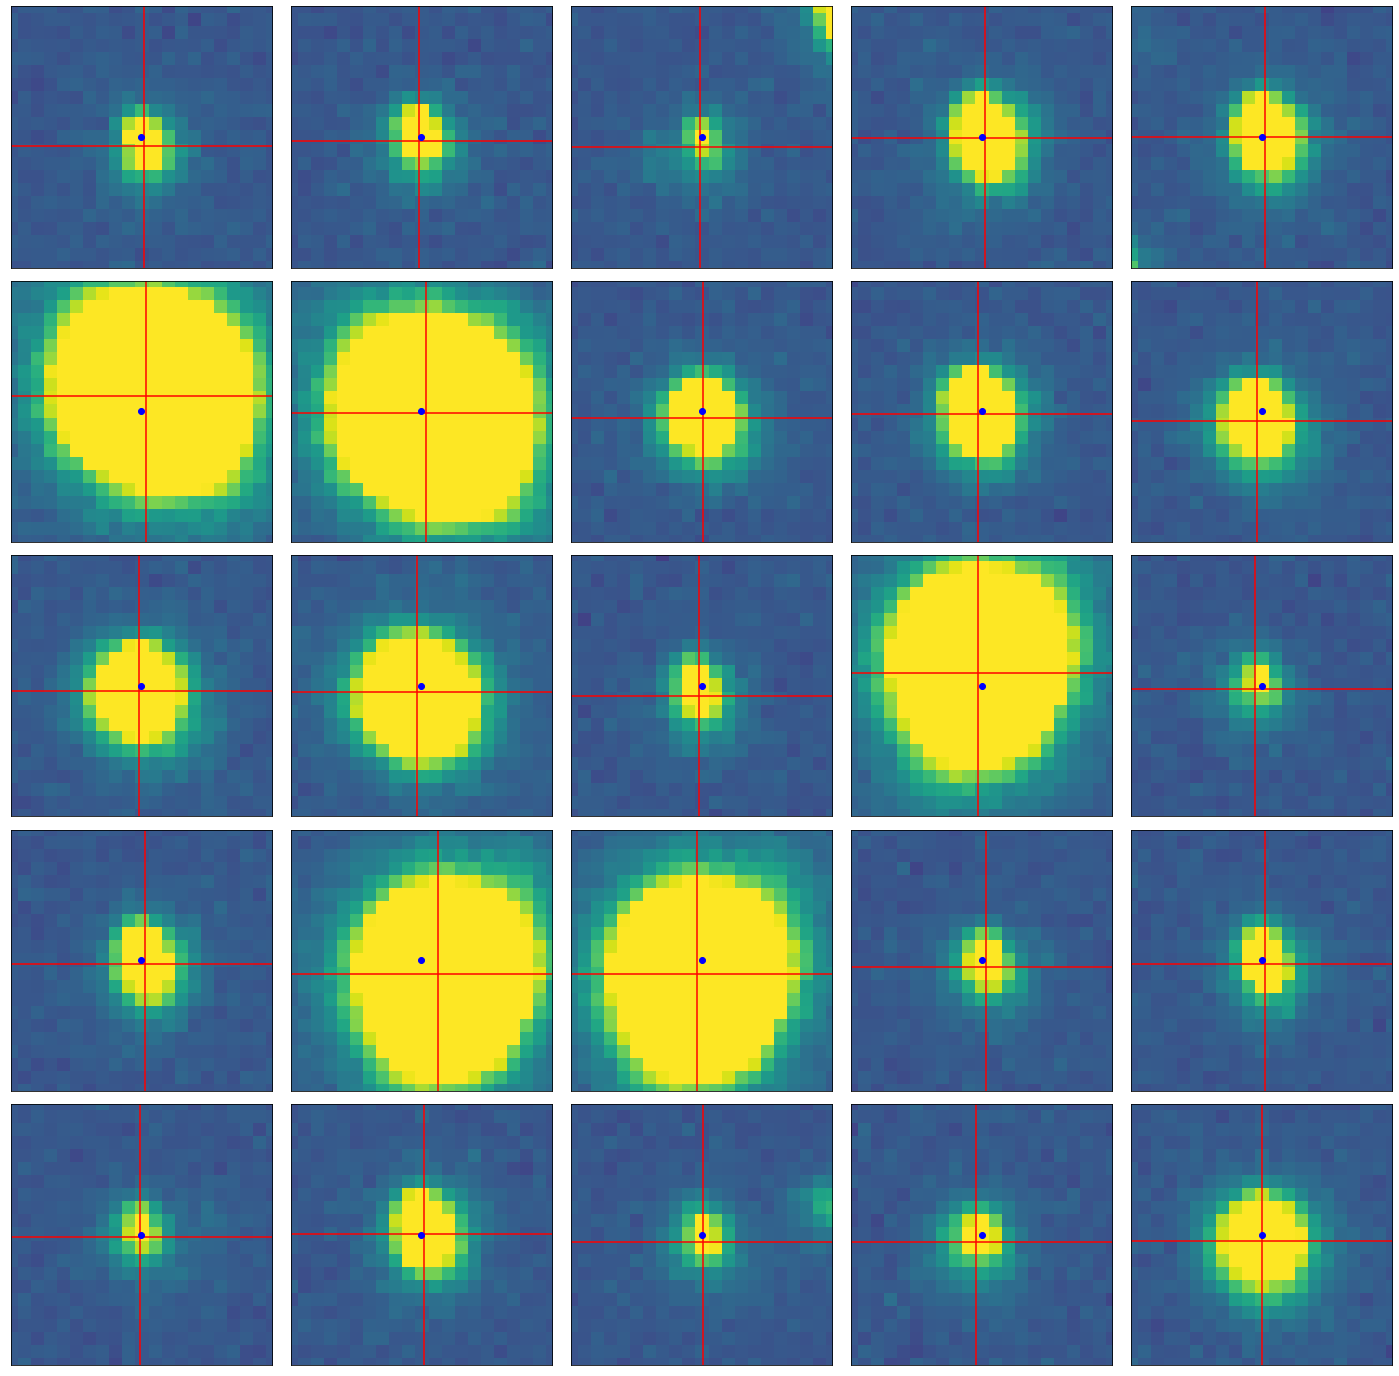

In [658]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask)
pipe.set_image_mask(mask)
peaks = pipe.findpeaks_maxfilter(threshold=np.mean(pipe.image)+3*np.std(pipe.image))
fig, ax = plt.subplots(5,5,figsize=(25,25))
ax = ax.flatten()
for n in range(25):
    loc = (peaks[n+10][1],peaks[n+10][0])
    testx,testy=pipe.centroid_peak(loc[0],loc[1],window=10)
    ax[n].imshow(pipe.image,origin='lower',vmin=m-5*s,vmax=m+5*s)
    ax[n].axhline(testy,color='r')
    ax[n].axvline(testx,color='r')
    ax[n].plot(loc[0],loc[1],'bo')
    ax[n].set_xlim(loc[0]-10,loc[0]+10)
    ax[n].set_ylim(loc[1]-10,loc[1]+10)
    ax[n].set_xticks([]) ; ax[n].set_yticks([])
    if n == 24:
        np.save('cutout.npy',pipe.image.data[loc[1]-10:loc[1]+10,loc[0]-10:loc[0]+10])
        print(loc)
fig.subplots_adjust(wspace=0.02,hspace=0.05)

### Problem 3.3

Now do this for all peaks in your image. You may need to use `try` and `except` blocks to skip any peaks that raise errors in your centroid code for being too close to the edge. I'll leave it to your discration whether you handle this by dropping that peak from the list and moving on, or by trying a smaller window first. (The second requires a bit more boiler plate but would allow you to retain a larger selection of stars).

In [672]:
all_cen = []
for i in range(len(peaks)):
    try:
        cx,cy = pipe.centroid_peak(peaks[i][1],peaks[i][0])
        all_cen.append([cx,cy])
    except AssertionError:
        continue
all_cen = np.array(all_cen)



### Problem 3.4
If you recall from above, you determined why the peak algorithm occasionally marked a bunch of pixels as peaks within the same star, which shouldn't happen. It should be clear from your answer that these stars will be unusable for the purposes of measuring the PSF of stars in the image. We thus need to remove these ~8-10 stars from our sample.

Write a function which takes in the list of centroids, and identifies these cases. The easiest way to do this is to simply iterate through the list of centroids and compute the distance to all other centroids in the list. Any centroid which has another centroid very nearby (within, say, 5 pixels) should be removed from our sample.

This function should return the final list of centroids for use. Plot them over the data to confirm these "stacked" peak cases have been removed.

In [705]:
#fig, ax = implot(pipe.image,scale=0.5)
out_cen = []
for i in range(len(all_cen)):
    sub2 = (all_cen - all_cen[i])**2
    sq = np.sum(sub2,axis=1)
    sqt = np.sqrt(sq)
    ind, = np.where(sqt<20)
    if len(ind) < 2:
        out_cen.append(all_cen[i])
out_cen = np.array(out_cen)
    

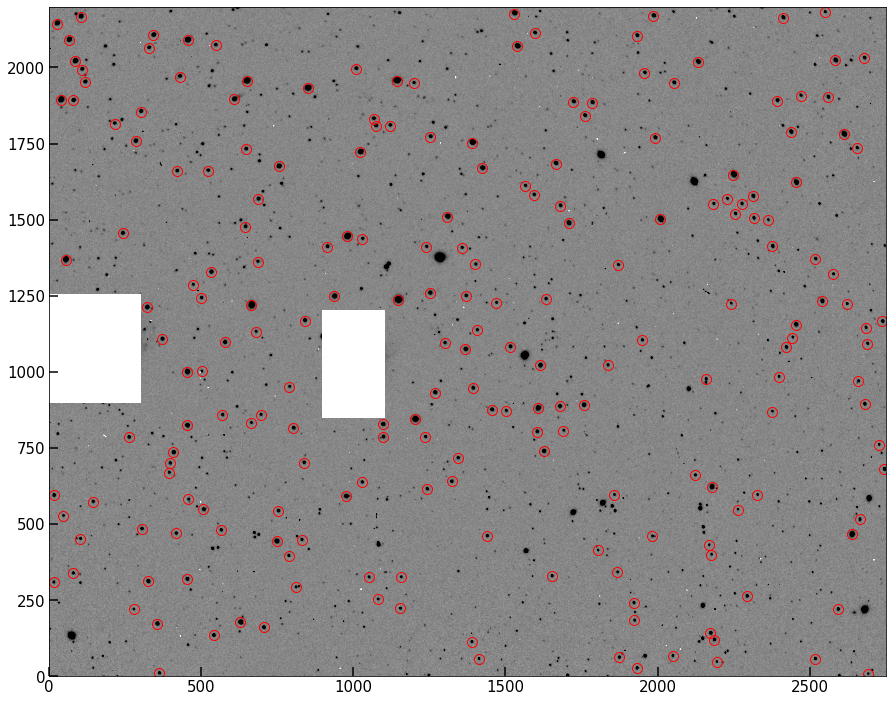

In [707]:
fig, ax = implot(pipe.image,scale=0.5)
ax.plot(out_cen[:,0],out_cen[:,1],'o',color='None',mec='r',ms=10)

I'm going to integrate the above two bits into my final method. 

### Problem 4.3 

Armed with a dark-subtracted, flat-fielded, background-subtracted image, as well as with a list of centroids corresponding to stars in our image, we are ready to estimate the PSF. 

There are two main functional forms typically used to fit star profiles: 2D Gaussians, and Moffat profiles (which combines the shapes of a Gaussian and Lorentzian to best match both the inner and outer regions of the PSF). 

We're going to use the [`Gaussian2D`](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html) class from `astropy` to do this:

In [433]:
from astropy.modeling.functional_models import Gaussian2D

For each star, a Gaussian2D profile (normalized) will be used "as the PSF". The parameters we need to know for this profile are $x,y$, for which we'll use the centroids we calculated earlier, the amplitude (set by the normalization), and $\sigma_x,\sigma_y$, the standard deviations in the two axes. For this lab, we're going to assume our stars are circular ($\sigma_x=\sigma_y$). This is a strictly incorrect, but not a bad assumption for most cases. All other optional arguments we won't need, primarily due to the assumption of circularity. 

```{note}
We are going to make a point estimate of the "size" of the stars in our image, which constrains us from using a more fancy model for the PSF. An example of a more sophisticated setup would be *fitting* a Gaussian or Moffat profile to every star, and in a Bayesian framework marginalizing over the stars to determine the best-fit PSF (including ellipticity, etc) for the image, or, even fancier, interpolating a PSF model which varies over the detector.
```

PSF photometry works by multiplying the *data* (say, a cutout around a star) by the *estimated PSF* during the fluxing stage. Instead of picking a radius and performing aperture photometry (which includes fully all pixels within the aperture and throws out all pixels beyond), this method attempts to weight each pixel fractionally by how likely it is to be stellar flux, with the weighting coming from the PSF of the detector. This means further pixels may still be included, but will contribute less than pixels near the center of the star. 

The formula for measuring the PSF flux of a star is 

$$
f_{\rm PSF} = \frac{\sum \hat{f_i} p_i}{\sum p_i^2},
$$

where $\hat{f_i}$ are the fluxes in your image and $p_i$ is your PSF estimate. This formula should be reminiscent of the centroiding formula; it's a similar weighting scheme.

`Gaussian2D` is a class, but we want to interact with it pretty simply, and have simplified inputs. I've made a quick wrapper function below which allows us to enter a single $\sigma$ and then $x,y$ grids created via `np.meshgrid()`, and creates the Gaussian and evaluates it on our grid. 

In [726]:
def eval_gauss(x_arr,y_arr,sigma_x,sigma_y,mu_x,mu_y):
    
    g = Gaussian2D.evaluate(x=x_arr,y=y_arr,amplitude=1,theta=0,x_mean=mu_x,
                   y_mean=mu_y,
                   x_stddev=sigma_x,
                   y_stddev=sigma_y)
    g/=np.sum(g)
    return g

In [491]:
xx, yy = np.meshgrid(np.arange(loc[0]-10,loc[0]+10),
                     np.arange(loc[1]-10,loc[1]+10))
model = eval_gauss(x_arr=xx,y_arr=yy,sigma=3,mu_x=testx,mu_y=testy)

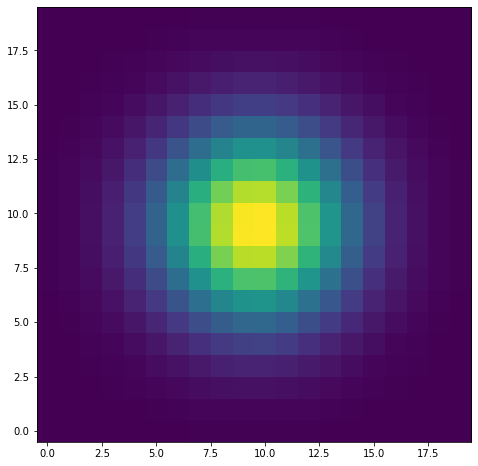

In [485]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(model,origin='lower')

As we can see, I now have a model for the PSF which I can easily create for given inputs. We're going to do this for cutouts around each star, and instead of a random $\sigma$, we're going to estimated it using the second moment (moment of inertia) of the star itself.

The formula for this (from Markevich et al. 1989) is 

$$
\sigma_x = \left[\frac{\sum x_i^2 \hat{f}_i}{\sum \hat{f}_i} - x_{\rm com}^2\right]^{1/2}
$$

$$
\sigma_y = \left[\frac{\sum y_i^2 \hat{f}_i}{\sum \hat{f}_i} - y_{\rm com}^2\right]^{1/2}
$$

In this case, we'll need to use `meshgrid()` directly within our second moment function, as you can see it depends on the difference between the pixels and the centroid.

Add a method to your class called `second_moment` which reads in an image cutout, the meshgrid input (xx,yy) (or constructs it), and finally, a centroid (x and y). Inside, use the formulas above to determine sigma_x and sigma_y, and return them

In [494]:
def second_moment(image_cutout,xx,yy,centroid_x,centroid_y):
    x_size, y_size = image_cutout.shape
    T = np.sum(image_cutout)
    T2x = np.sum(xx**2 * image_cutout)
    T2y = np.sum(yy**2 * image_cutout)
    sigma_x = np.sqrt(T2x/T - centroid_x**2)
    sigma_y = np.sqrt(T2y/T - centroid_y**2)
    return sigma_x, sigma_y

In [495]:
second_moment(model,xx,yy,testx,testy)

(2.9221417526244626, 2.9860561887708132)

Within 10%, this calculation, which requires no fitting, tells us $\sigma$ (under the assumption the distribution is Gaussian). Thus, by running out image cutouts through this function, we can derive for ourselves a good $\sigma$ to choose in our Gaussian model of the PSF. 

### Problem 4.4 

We now have everything we need to run our pipeline. 

Right now, our final three methods (peak finder, centroider, and width-finder) all *return* their values. I had you do it that way for testing purposes. To finalize our "object oriented pipeline" though, we should adapt these. 

Modify your peak-finder method to save the peaks to a class attribute. 

We'll leave the centroid and second moment functions alone, since they act on individual stars. Instead, we'll write a new, final method called `psf_photometry`. When the user runs this method, it should first feed the peaks into the centroid code one by one, assembling a set of centroids. It should then construct cutouts of `self.image` around each peak (or centroid), and feed those, plus the centroids, into the second moment function to save a pair sigma_x and sigma_y for each star as well. And finally, it should use the eval_gauss function I've provided above to carry out the PSF photometry. 

At the end of it all, you can save the centroids, widths, and psf-fluxes all to class attributes, where they will remain accessible. You can also find a nice way to return them (see below).

In [783]:
import pandas as pd 
class PSFPhot():
    def __init__(self,data_fpath,dark_fpath,flat_fpath):
        self.data_header, self.data_init = load_fits(data_fpath)
        self.data_calibrated = self.flat_field(self.dark_subtract(self.data_init,dark_fpath),flat_fpath)
    
    def dark_subtract(self,image,dark_path):
        h,dark_im = load_fits(dark_path)

        return np.subtract(image,dark_im)
    
    def flat_field(self,image,flat_path):
        h,flat_im = load_fits(flat_path)
        flat_im/=np.max(flat_im)
        return image/flat_im

    def subtract_background(self,mask=None):
        data_corder = self.data_calibrated.copy(order='C')
        bkg = sep.Background(data_corder, mask=mask)
        self.background = bkg.back()
        self.image = self.data_calibrated - self.background
        print('Background estimated; output saved to attribute image')
    
    def set_image_mask(self,mask):
        if hasattr(self,'image'):
            self.image = np.ma.masked_array(self.image,mask=mask)
        else:
            self.image = np.ma.masked_array(self.data_calibrated,mask=mask)
   
    def findpeaks_maxfilter(self,threshold=0):
            '''
            Algorithm for finding peaks (above a threshold) in an image

            Parameters
            ----------
            image: array_like
                2D array containing the image of interest.
            threshold: float
                minimum pixel value for inclusion in search

            Returns
            -------
            peaks: array_like
                array containing the x and y coordinates of peak regions.
            '''
            neighborhood = np.ones((3,3),dtype=bool) # just 3x3 True, defining the neighborhood over which to filter
            # find local maximum for each pixel
            amax = maximum_filter(self.image, footprint=neighborhood) #max filter will set each 9-square region in the image to the max in that region.

            peaks = np.where((self.image == amax) & (self.image >= threshold)) #find the pixels unaffected by the max filter.
            peaks = np.array([peaks[1],peaks[0]]).T
            out_peaks = []
            for i in peaks:
                peak_flux = image[i[1],i[0]]
                mini_cutout = image[i[1]-1:i[1]+2,i[0]-1:i[0]+2]
                accept = np.where(mini_cutout>0.5*peak_flux)
                if len(accept[0]) > 7:
                    out_peaks.append(i)
            return np.array(out_peaks)
    
    def calc_moments(self,x,y,window=5):
        image_cutout = self.image[y-window:y+window,x-window:x+window]
        xx,yy = np.meshgrid(np.arange(x-window,x+window),
                            np.arange(y-window,y+window))
        T = np.sum(image_cutout)
        cutout_flux = T
        centroid_x = np.sum(image_cutout*xx)/T
        centroid_y = np.sum(image_cutout*yy)/T
        T2x = np.sum(xx**2 * image_cutout)
        T2y = np.sum(yy**2 * image_cutout)
        sigma_x = np.sqrt(T2x/T - centroid_x**2)
        sigma_y = np.sqrt(T2y/T - centroid_y**2)
        model = eval_gauss(x_arr=xx,y_arr=yy,sigma_x=sigma_x,sigma_y=sigma_y,mu_x=centroid_x,mu_y=centroid_y)
        psf_flux = np.sum(image_cutout*model) / np.sum(model**2)
        return centroid_x,centroid_y,sigma_x, sigma_y, cutout_flux,psf_flux

    def aperture_photometry(self,window=10):
        peaks = self.findpeaks_maxfilter(threshold=np.mean(self.image)+3*np.std(self.image))
        print('Found Peaks')
        
        star_properties = []
        for i in range(len(peaks)):
            if (peaks[i][0]>window) and (peaks[i][0]<self.image.shape[1]-window):
                if (peaks[i][1]>window) and (peaks[i][1]<self.image.shape[0]-window):
                    cx,cy,sigx,sigy,cutout_flux,psf_flux = self.calc_moments(peaks[i][0],peaks[i][1],window=window)
                    star_properties.append([cx,cy,sigx,sigy,cutout_flux,psf_flux])
        print('Centroided and Second Moment Measured the Peaks')
        star_properties = np.array(star_properties)  
        out_props = []
        for i in range(len(star_properties)):
            sub2 = (star_properties[:,0:1] - all_cen[i,0:1])**2
            sq = np.sum(sub2,axis=1)
            sqt = np.sqrt(sq)
            ind, = np.where(sqt<5)
            if len(ind) < 2:
                out_props.append(star_properties[i])
        out_props = np.array(out_props)
        print('Removed Saturated Stars')
        df = pd.DataFrame()
        df['centroid_x'] = out_props[:,0]; df['centroid_y'] = out_props[:,1]
        df['sigma_x'] = out_props[:,2]; df['sigma_y'] = out_props[:,3]
        df['cutout_flux'] = out_props[:,4]; df['psf_flux'] = out_props[:,5]
        self.flux_table = df
        return df
        
        
        

In [784]:
pipe = PSFPhot('2020-04-15-0001.fits',
               dark_fpath='2020-04-15-dark.fits',
               flat_fpath='2020-04-15-flat.fits')
pipe.subtract_background(mask)
pipe.set_image_mask(mask) 
df = pipe.aperture_photometry(window=6)


Background estimated; output saved to attribute image
Found Peaks
Centroided and Second Moment Measured the Peaks
Removed Saturated Stars


<ipython-input-783-d6b08dd593c6>:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_x = np.sqrt(T2x/T - centroid_x**2)


In [785]:
df

centroid_x   centroid_y   sigma_x   sigma_y    cutout_flux  \
0     362.655705    10.326548  1.886595  1.976730  184779.849982   
1    2193.767467    46.944986  1.800662  1.950200   64483.041675   
2    1412.435090    57.018075  1.823663  2.019020   83374.606011   
3     705.665737   160.209360  1.931244  2.033910  320015.727883   
4     355.806723   172.542875  1.962915  2.065964  578935.400071   
..           ...          ...       ...       ...            ...   
105  1932.118494  2103.867512  2.301403  2.320404  198417.480753   
106  1596.192032  2112.402385  2.307307  2.296160  174719.526438   
107  2411.836096  2162.730994  2.102614  2.329944  291193.386076   
108   105.318450  2166.163610  2.520967  2.551289  464461.888789   
109  2549.764488  2180.724678  2.118850  2.254683   89694.423134   

          psf_flux  
0    196567.032561  
1     69128.800476  
2     90812.510783  
3    340472.820597  
4    611639.609731  
..             ...  
105  196641.333693  
106  174677.408344  
107  289959.501256  
108  441463.111353  
109   89104.358988  

[110 rows x 6 columns]

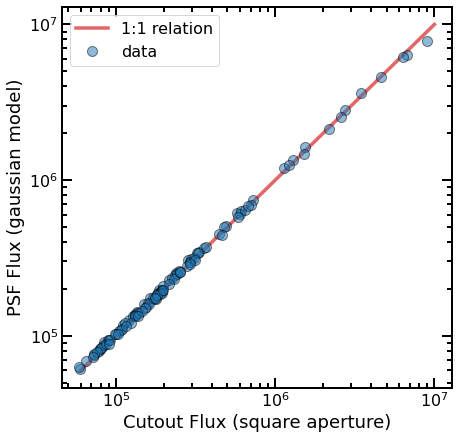

In [813]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot([6e4,1e7],[6e4,1e7],lw=3.5,color='C3',alpha=0.7,label='1:1 relation')
ax.plot(df.cutout_flux,df.psf_flux,'o',alpha=0.5,mec='k',ms=10,label='data')

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize=16)
ax.tick_params(which='major',length=10,width=2)
ax.tick_params(which='minor',length=5,width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_xlabel('Cutout Flux (square aperture)',fontsize=18)
ax.set_ylabel('PSF Flux (gaussian model)',fontsize=18)
ax.legend(loc=2,prop={'size': 16});

## Bonus Problem (+1 Extra Credit)

A convenient way to return the set of measurements carried out by our pipeline is via a `flux table`, like the one returned by `aperture_photometry` from `astropy`. For our purposes, since we'll be spending a lot of time with data frames, let's go with that. 

Modify your final `psf_photometry` method to assemble a nice `DataFrame` which contains as colummns `peak_x`, `peak_y`, `centroid_x`, `centroid_y`, `width_x`, `width_y`, and `psf_flux`. Each row should be the relevant values for a given star that was originally found by your peakfinder (but which made it through our sample cleaning stage). 

```{tip}
Inside your final method, you probably have lists or arrays containing the output of your centroid and width methods as they looped over the stars (and your find peak function returns a list of positions outright). So if you set up an empty DataFrame, you can set, e.g., `df['peak_x'] = peaks[:,0]` or something like `df['width_x'] = out_widths`, to set up these columns. As long as you never messed with the order of the lists, it should turn into the desired output frame.
```

(see above)